In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
 
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
memoryloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def evaluate_model(model, test_loader, num_classes=10):
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for idxes, (pos, target) in enumerate(test_loader,0):
            pos = pos.to(device)
            target = target.to(device)
            outputs= model(pos)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct/total


In [4]:
model = Net()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)


In [5]:
val_acc = []
train_acc = []
for epoch in range(2):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):   # enumerate可以接收第二个参数，用于指定索引起始值
        inputs, labels = inputs.to(device), labels.to(device)
 
        optimizer.zero_grad()
 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # writer.add_scalar("loss", loss.item(), epoch)
 
        running_loss += loss.item()  # 将torch.tensor变量loss.data变为realnumber(真实数据)loss.data[0]
    train_acc.append(evaluate_model(model, memoryloader))
    val_acc.append(evaluate_model(model, testloader))
# writer.close()
print('Finished Training')

Finished Training


In [6]:
train_acc = np.array(train_acc)
np.save('../data/train_acc.npy', train_acc)
val_acc = np.array(val_acc)
np.save('../data/val_acc.npy', val_acc)

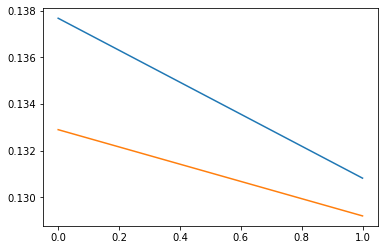

In [7]:
a1 = np.load('../data/train_acc.npy')
a2 = np.load('../data/val_acc.npy')
from matplotlib import pyplot as plt
plt.plot(a1)
plt.plot(a2)
plt.show()